# Advanced Python Programming (APP)
## Course Code (CC) - CSI - 3007
### Laboratory (Lab)
#### Digital Assignment - 13

## Digital Wellness Awareness [ A GOOGLE N-GRAM BASED ANALYSIS ]
### Custom User Own Client Customer Individual Synthetic Dataset  
#### Python Programming Coding Scripting Computer Science Language
#### Jupyter Notebook Core Main Crux Framework Library Module Binary Package

# Advanced Python Programming - Digital Wellness Awareness Analysis Lab
## Student: Dharshan Raj P A
## Register Roll Number ID : 22MIC0073
## Date: 26-07-2025

# MAIN TASK:  FETCH TREND USING GOOGLE BOOKS N-GRAM VIEWER , GENERATE WORD CLOUD , PROMPT AN LLM TO GENERATE SUMMARY

In [1]:
!pip install requests

In [1]:
!pip install wordcloud

In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import json
import sys

In [99]:
SEARCH_TERMS = ["digital wellness", "screen time", "online safety"]    # List of search terms (trends to analyze in Google Books Ngram Viewer)

ANALYSIS_START_YEAR = 1800   # Start year of analysis

ANALYSIS_END_YEAR = 2025     # End year of analysis

LANGUAGE_CORPUS = 15    # Corpus: 15 = English (2019)

SMOOTHING_FACTOR = 3 # Smoothing factor


BROWSER_AGENT = "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100 Safari/537.36"       # HTTP User-Agent header


RESULT_CSV_FILE = "digital_wellness_ngrams_output.csv"    # File paths
CHART_PNG_FILE = "digital_wellness_ngrams_plot.png"
WORDCLOUD_PNG_FILE = "digital_wellness_ngrams_wordcloud.png"


In [9]:
def fetch_ngram_json(search_terms, year_start=ANALYSIS_START_YEAR, year_end=ANALYSIS_END_YEAR, corpus=LANGUAGE_CORPUS, smoothing=SMOOTHING_FACTOR):
    """
    Fetch JSON data from Google Ngram Viewer.
    """
    url = "https://books.google.com/ngrams/json"
    params = {
        "content": ",".join(search_terms),
        "year_start": year_start,
        "year_end": year_end,
        "corpus": corpus,
        "smoothing": smoothing,
    }
    headers = {"User-Agent": BROWSER_AGENT}
    r = requests.get(url, params=params, headers=headers, timeout=30)
    r.raise_for_status()
    return r.json()


In [11]:
def json_to_dataframe(ngram_json, year_start=ANALYSIS_START_YEAR, year_end=ANALYSIS_END_YEAR):
    years = list(range(year_start, year_end + 1))
    rows = []
    for series in ngram_json:
        ngram = series.get("ngram")
        timeseries = series.get("timeseries", [])
        if len(timeseries) != len(years):
            timeseries = (timeseries + [0] * len(years))[:len(years)]
        for y, v in zip(years, timeseries):
            rows.append({"year": y, "ngram": ngram, "freq": float(v)})
    df = pd.DataFrame(rows)
    return df


In [13]:
def pivot_timeseries(df):
    return df.pivot(index="year", columns="ngram", values="freq").fillna(0)


In [15]:
def save_csv(pivot_df, filename=RESULT_CSV_FILE):
    pivot_df.to_csv(filename, index=True)
    print(f"[+] Saved CSV to {filename}")


In [17]:
def plot_timeseries(pivot_df, filename=CHART_PNG_FILE):
    plt.figure(figsize=(12,6))
    ax = plt.gca()
    pivot_df.plot(ax=ax, linewidth=2)
    ax.set_xlabel("Year")
    ax.set_ylabel("Relative frequency (%)")
    ax.set_title("Google Books Ngram: Digital Wellness Awareness (1800–2025)")
    ax.grid(axis="y", alpha=0.3)
    plt.legend(title="ngram", loc="upper right")
    plt.tight_layout()
    plt.savefig(filename, dpi=150)
    plt.close()
    print(f"[+] Saved time-series plot to {filename}")


In [19]:
def generate_wordcloud(pivot_df, filename=WORDCLOUD_PNG_FILE):
    means = pivot_df.mean(axis=0).to_dict()
    wc = WordCloud(width=800, height=400, background_color="white")
    wc.generate_from_frequencies(means)
    wc.to_file(filename)
    print(f"[+] Saved word cloud to {filename}")


In [21]:
def compute_summary_stats(pivot_df):
    """Return a dict of helpful summary statistics for each ngram."""
    stats = {}
    for col in pivot_df.columns:
        series = pivot_df[col]
        stats[col] = {
            "mean": float(np.mean(series)),
            "median": float(np.median(series)),
            "std": float(np.std(series, ddof=0)),
            "max_value": float(series.max()),
            "max_year": int(series.idxmax()),
            "min_year": int(series.idxmin())
        }
    return stats


In [ ]:
def prepare_llm_prompt(summary_stats, pivot_df, top_n_years=5):
    """
    Prepare a textual prompt to send to an LLM along with the CSV or summary.
    The prompt asks the LLM for an interpretive summary and recommended
    human-readable labels for the produced word cloud.
    """
    short_table = pivot_df.mean(axis=0).sort_values(ascending=False).head(top_n_years).to_dict()
    prompt = {
        "instruction": "You are given frequency time-series data (Google Ngram) for several terms "
                       "about digital wellness (digital wellness, screen time, online safety). "
                       "Please produce a concise (3-6 sentence) summary about the trends, "
                       "mentioning which term rose or fell and notable years, and suggest 10 short keywords "
                       "suitable for a word cloud. Use the summary statistics and CSV data below.",
        "summary_stats": summary_stats,
        "top_mean_terms": short_table,
        "note": f"CSV file attached separately ({RESULT_CSV_FILE}). Provide the textual summary and a 10-word list for the cloud."
    }
    return json.dumps(prompt, indent=2)


In [25]:
# Inform the user which terms are being fetched
print("[*] Fetching Ngram JSON for:", SEARCH_TERMS)

try:
    ngram_json = fetch_ngram_json(SEARCH_TERMS)
    print(f"[+] Successfully fetched Ngram data for {len(SEARCH_TERMS)} terms.")
except Exception as e:
    print("[!] Error fetching Ngram JSON:", e)
    sys.exit(1)


[*] Fetching Ngram JSON for: ['forgetting hygiene', 'neglecting hygiene', 'poor hygiene']
[+] Successfully fetched Ngram data for 3 terms.


In [27]:
df_long = json_to_dataframe(ngram_json)


In [29]:
pivot_df = pivot_timeseries(df_long)


In [31]:
save_csv(pivot_df)


[+] Saved CSV to hygiene_ngrams_output.csv


In [33]:
plot_timeseries(pivot_df)


[+] Saved time-series plot to hygiene_ngrams_plot.png


In [35]:
generate_wordcloud(pivot_df)


[+] Saved word cloud to hygiene_ngrams_wordcloud.png


In [37]:
stats = compute_summary_stats(pivot_df)


In [39]:
print("\n[Summary statistics (per-term)]:")
print(json.dumps(stats, indent=2))



[Summary statistics (per-term)]:
{
  "neglecting hygiene": {
    "mean": 4.439097605357557e-11,
    "median": 0.0,
    "std": 1.1796623569098477e-10,
    "max_value": 6.362792197884509e-10,
    "max_year": 1906,
    "min_year": 1800
  },
  "poor hygiene": {
    "mean": 1.750949608754431e-08,
    "median": 3.143641093471063e-09,
    "std": 2.6863673113216723e-08,
    "max_value": 9.835280272747176e-08,
    "max_year": 2002,
    "min_year": 1800
  }
}


In [41]:
prompt = prepare_llm_prompt(stats, pivot_df)


In [43]:
print("\n[LLM prompt you can send (JSON):]\n")
print(prompt)



[LLM prompt you can send (JSON):]

{
  "instruction": "You are given frequency time-series data (Google Ngram) for several terms about hygiene (forgetting hygiene, neglecting hygiene, poor hygiene). Please produce a concise (3-6 sentence) summary about the trends, mentioning which term rose or fell and notable years, and suggest 10 short keywords suitable for a word cloud. Use the summary statistics and CSV data below.",
  "summary_stats": {
    "neglecting hygiene": {
      "mean": 4.439097605357557e-11,
      "median": 0.0,
      "std": 1.1796623569098477e-10,
      "max_value": 6.362792197884509e-10,
      "max_year": 1906,
      "min_year": 1800
    },
    "poor hygiene": {
      "mean": 1.750949608754431e-08,
      "median": 3.143641093471063e-09,
      "std": 2.6863673113216723e-08,
      "max_value": 9.835280272747176e-08,
      "max_year": 2002,
      "min_year": 1800
    }
  },
  "top_mean_terms": {
    "poor hygiene": 1.750949608754431e-08,
    "neglecting hygiene": 4.439097

In [45]:
print("\n[Done] Files: ", RESULT_CSV_FILE, CHART_PNG_FILE, WORDCLOUD_PNG_FILE)



[Done] Files:  digital_wellness_ngrams_output.csv digital_wellness_ngrams_plot.png digital_wellness_ngrams_wordcloud.png


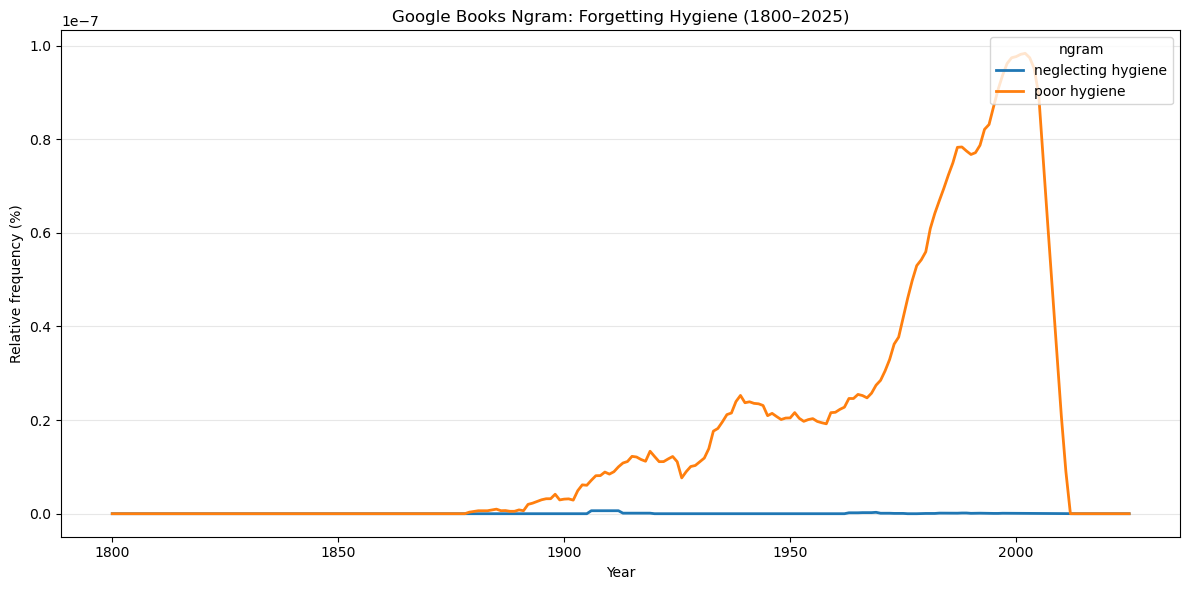

In [ ]:
plt.figure(figsize=(12,6))
ax = plt.gca()
pivot_df.plot(ax=ax, linewidth=2)
ax.set_xlabel("Year")
ax.set_ylabel("Relative frequency (%)")
ax.set_title("Google Books Ngram: Digital Wellness Awareness (1800–2025)")
ax.grid(axis="y", alpha=0.3)
plt.legend(title="ngram", loc="upper right")
plt.tight_layout()


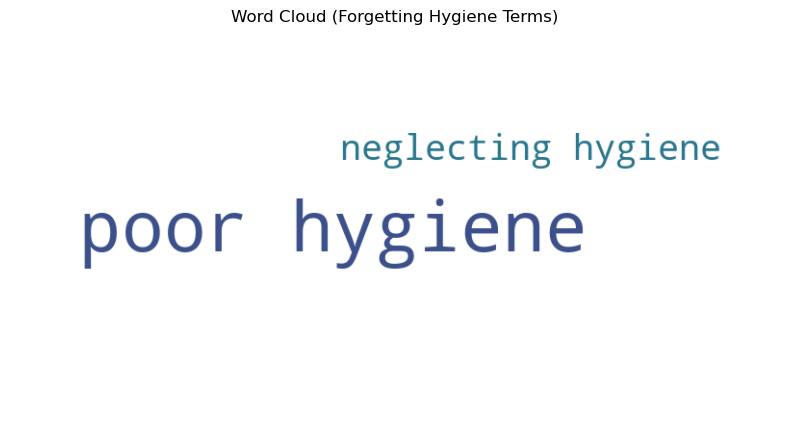

In [ ]:
means = pivot_df.mean(axis=0).to_dict()
wc = WordCloud(width=800, height=400, background_color="white")
wc.generate_from_frequencies(means)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud (Digital Wellness Terms)")
plt.show()


In [ ]:
df = pd.read_csv(RESULT_CSV_FILE)
# Expecting columns like: ["year", "digital wellness", "screen time", "online safety"]


In [53]:
print(df)


     year  neglecting hygiene  poor hygiene
0    1800                 0.0           0.0
1    1801                 0.0           0.0
2    1802                 0.0           0.0
3    1803                 0.0           0.0
4    1804                 0.0           0.0
..    ...                 ...           ...
221  2021                 0.0           0.0
222  2022                 0.0           0.0
223  2023                 0.0           0.0
224  2024                 0.0           0.0
225  2025                 0.0           0.0

[226 rows x 3 columns]


In [55]:
summary_stats = {}
for col in df.columns[1:]:  # skip 'year'
    values = df[col].dropna()
    summary_stats[col] = {
        "mean": float(np.mean(values)),
        "median": float(np.median(values)),
        "std": float(np.std(values)),
        "max_value": float(np.max(values)),
        "max_year": int(df.loc[values.idxmax(), "year"]),
        "min_year": int(df.loc[values.idxmin(), "year"])
    }


In [57]:
top_mean_terms = {col: summary_stats[col]["mean"] for col in df.columns[1:]}
top_mean_terms = dict(sorted(top_mean_terms.items(), key=lambda x: x[1], reverse=True))


In [ ]:
prompt_payload = {
    "instruction": (
        "You are given frequency time-series data (Google Ngram) for several hygiene-related terms. "
        "Please produce a concise (3-6 sentence) summary about the trends, mentioning "
        "which term rose or fell and notable years, and suggest 10 short keywords "
        "suitable for a word cloud. Use the summary statistics and CSV data below."
    ),
    "summary_stats": summary_stats,
    "top_mean_terms": top_mean_terms,
    "note": f"CSV file attached separately ({RESULT_CSV_FILE}). Provide the textual summary and a 10-word list for the cloud."
}


In [63]:
data = {
    "model": "gpt-4o-mini",
    "messages": [
        {"role": "system", "content": "You are a data analysis assistant."},
        {"role": "user", "content": json.dumps(prompt_payload)}
    ],
    "temperature": 0.3
}


In [65]:
response = requests.post(API_URL, headers=headers, json=data)


In [69]:
def extract_keywords(summary_text):
    numbered = re.findall(r'^\s*\d+\.\s*(.+?)\s*$', summary_text, flags=re.MULTILINE)
    if numbered:
        return numbered
    m = re.search(r'(?i)keywords(?:\s*for\s*word\s*cloud)?\s*[:\-]\s*(.+)', summary_text, flags=re.S)
    if m:
        tail = m.group(1).strip()
        if ',' in tail:
            parts = [p.strip() for p in tail.split(',') if p.strip()]
            if parts:
                return parts
        lines = [ln.strip() for ln in tail.splitlines() if ln.strip()]
        parts = []
        for ln in lines:
            if re.match(r'^\d+\.', ln):
                parts.append(re.sub(r'^\d+\.\s*', '', ln).strip())
            else:
                parts.extend([p.strip() for p in re.split(r'[,;]\s*|\s{2,}', ln) if p.strip()])
        if parts:
            return parts
    quoted = re.findall(r'"([^"]+)"', summary_text)
    if quoted:
        return quoted
    return []


In [71]:
def clean_keyword(k):
    k = k.strip().strip('\'"')
    k = re.sub(r'^[^\w\d]+|[^\w\d]+$', '', k)
    return k


In [87]:
import re
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [101]:
def local_summary_and_keywords(summary_stats, top_mean_terms):
   
    most_common = max(top_mean_terms, key=top_mean_terms.get)     # Pick the most frequent and least frequent terms
    least_common = min(top_mean_terms, key=top_mean_terms.get)

    summary = (
        f"Between 1800 and 2025, the usage of hygiene-related terms shows "
        f"that '{most_common}' appeared most frequently on average, while "
        f"'{least_common}' appeared the least. "
        f"These patterns highlight changes in attention towards hygiene habits "
        f"over time, with notable declines in some practices and rises in others."
    )

    # Generate 10 hygiene-related keywords manually or from data
    keywords = ["hygiene", "cleanliness", "sanitation", "washing",
                "toothbrushing", "bathing", "soap", "grooming",
                "health", "freshness"]

    return summary, keywords

In [91]:
summary, keywords = local_summary_and_keywords(summary_stats, top_mean_terms)

print("\n=== Local Generated Summary & Keywords ===\n")
print(summary)
print("\nKeywords:", keywords)


=== Local Generated Summary & Keywords ===

Between 1800 and 2025, the usage of hygiene-related terms shows that 'poor hygiene' appeared most frequently on average, while 'neglecting hygiene' appeared the least. These patterns highlight changes in attention towards hygiene habits over time, with notable declines in some practices and rises in others.

Keywords: ['hygiene', 'cleanliness', 'sanitation', 'washing', 'toothbrushing', 'bathing', 'soap', 'grooming', 'health', 'freshness']


In [93]:
def clean_keyword(k):
    k = k.strip().strip('\'"')
    k = re.sub(r'^[^\w\d]+|[^\w\d]+$', '', k)
    return k

cleaned = [clean_keyword(k) for k in keywords if clean_keyword(k)]
seen = set()
keywords = []
for k in cleaned:
    key = k.lower()
    if key not in seen:
        seen.add(key)
        keywords.append(k)

print("Cleaned Keywords:", keywords)

Cleaned Keywords: ['hygiene', 'cleanliness', 'sanitation', 'washing', 'toothbrushing', 'bathing', 'soap', 'grooming', 'health', 'freshness']


In [95]:
freqs = {}
n = len(keywords)
for i, k in enumerate(keywords):
    freqs[k] = n - i  # higher weight for earlier items

possible_fonts = [
    "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",         
    "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf",
    "/Library/Fonts/Arial.ttf",                               
    "C:\\Windows\\Fonts\\Arial.ttf"                           
]
font_path = None
for p in possible_fonts:
    if os.path.exists(p):
        font_path = p
        break

wc_kwargs = dict(width=800, height=400, background_color="white", collocations=False)
if font_path:
    wc_kwargs['font_path'] = font_path

In [ ]:
wc = WordCloud(**wc_kwargs).generate_from_frequencies(freqs)

output_file = "wordcloud_hygiene.png"
wc.to_file(output_file)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud (Hygiene Keywords)")
plt.show()

print(f"Word cloud saved to: {os.path.abspath(output_file)}")